# Working with Decision Tree Machine Learning Algorithm
In this workshop, we will be:
1. working on vizualizing a dataset
2. training a Decision Tree algorithm
3. vizualizing the Decision Tree model generated
4. making some predictions using our model

### Set up the kernel
You must follow [this link](https://wiki.uiowa.edu/display/hpcdocs/Conda) first before continuing the workshop. It will have you set up your own Kernel so that you can have permission to install needed libraries. If you already have a kernel you made (most likely named "Python 3.8") then you can skip this and continue.

### Set up the environment
Once you have your kernel made and in use, we need to set up the python environment by importing some libraries. Run the following 2 cells below to install and load all libraries.

In [22]:
%conda install matplotlib scikit-learn pandas seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np # For setting random seed
np.random.seed(12345) # We will use a random seed so we all get same output

import matplotlib.pyplot as plt # Visualization
import pandas as pd # Loading and working on data
import seaborn as sns # Visualisation
from sklearn import tree # Decision Tree
from sklearn.model_selection import train_test_split # Splitting the dataset into 2 separate datasets
from sklearn.model_selection import cross_val_score # Computing cross validation
from sklearn.metrics import f1_score # Used in testing model when done
from IPython.display import Image # Visualize Decision Tree

%matplotlib inline
sns.set(color_codes=True)


# 1. Working on Visualizing Dataset
The dataset, and other information, we will be using is found [here](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq)

This dataset:
- Used in: Weinstein, John N., et al. 'The cancer genome atlas pan-cancer analysis project.' Nature genetics 45.10 (2013): 1113-1120.
- Maintained by: cancer genome atlas pan-cancer analysis project

You do not need to download anything. The data and labels (you will learn more about these later) are already found in this folder as CSV files.

### What data are we looking at?
All the data stored in data.csv is "RNA-Seq gene expression levels measured by illumina HiSeq platform" (as mentioned on the dataset webpage). The first column in the data.csv file is the "name" of the sample that is being sequenced. Each column after the first is a gene.

### What is the problem?
The goal of this dataset is to try and train a Machine Learning algorithm to predict what type of cancer a sample is based on the gene expression levels for a set number of genes.

In [24]:
# Load the dataset and the labels (cancer type for each sample)
samples_df = pd.read_csv('data.csv', index_col="sample_id")
labels_df = pd.read_csv('labels.csv', index_col="sample_id")

In [25]:
# Let's see how many samples we are working with in the dataset..
print(f"Number of samples (datapoints) in the dataset: {samples_df.shape[0]}")

# Dataset should not have any null values, this should be 0. 
# All values should either be 0 or some amount of expression, but not null (empty).
print(f"Number of null values in dataset: {samples_df.isnull().sum().sum()}")

# What cancers are we looking to predict for?
print(f"Cancers that we will try to predict for: {pd.unique(labels_df['Class'])}")

Number of samples (datapoints) in the dataset: 801
Number of null values in dataset: 0
Cancers that we will try to predict for: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


In [26]:
# Lets see the first 5 samples in the dataset to see how the data looks
samples_df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_16373,gene_16374,gene_16375,gene_16376,gene_16377,gene_16378,gene_16379,gene_16380,gene_16381,gene_16382
sample_id,,,,,,,,,,,,,,,,,,,,,
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0,7.175175,0.591871,0.0,0.0,...,8.750533,7.421257,4.692126,1.334282,1.650856,3.973382,0.000000,9.291933,0.840926,7.886642
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0,6.816049,0.000000,0.0,0.0,...,6.638879,7.991732,5.709045,0.811142,2.717824,3.255773,1.590818,3.467410,1.178045,8.864223
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0,6.972130,0.452595,0.0,0.0,...,8.205754,10.375778,1.839758,0.000000,3.004897,0.796598,0.000000,5.533710,0.225892,9.843799
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0,7.843375,0.434882,0.0,0.0,...,8.093185,8.424771,5.502251,0.434882,2.207862,1.039419,0.000000,8.358278,0.377401,7.701320
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0,6.566967,0.360982,0.0,0.0,...,7.522228,12.176650,10.305423,0.360982,1.099497,0.360982,0.649386,9.315607,1.052833,10.646325


### Data review
From the out of the above cell, we can see that there are 16,383 genes given for each sample. Along with that, we know from earlier that we have 801 samples in our dataset. That means the CSV file has $16,383 * 801 = 13,122,783$ total cells in it that hold our gene expression data. That is quite a lot!

### Histogram plots
Let's see what some genes look like. Below, we will plot 4 different genes histograms to see where the most gene expressions lie for them. So far, we know how many samples we have, how many genes each sample contains, and what the gene expression data looks like. However, we do not know what that gene expression data looks like overall. Here are a few questions to ask before running the next cell:
1. Do you think all genes show similar expression over all the samples?
2. How wide is the expression level distribution for each gene? (Are genes most likely narrow distributions, wide, bell curves, etc?)
3. Do some genes share similar distributions?

When working with Machine Learning, it is important to know your data before even thinking of the algorithm. This is especially important for Decision Trees as they focus on differences in the data itself more so than using mathematics to learn.

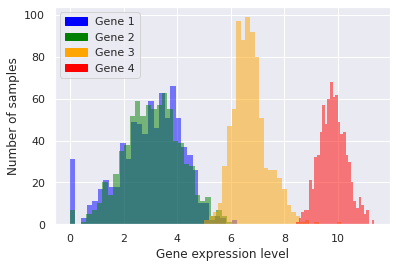

In [27]:
# Plot the histograms of 4 different genes
plt.hist(samples_df.gene_1, color="blue", lw=0, bins=30, alpha=0.5)
plt.hist(samples_df.gene_2, color="green", lw=0, bins=30, alpha=0.5)
plt.hist(samples_df.gene_3, color="orange", lw=0, bins=30, alpha=0.5)
plt.hist(samples_df.gene_4, color="red", lw=0, bins=30, alpha=0.5)

# Set the labels for the X and y axis
plt.xlabel('Gene expression level')
plt.ylabel('Number of samples')

# Set up the legend
from matplotlib.patches import Rectangle
handles = [Rectangle((0,0),1,1,color="blue"), Rectangle((0,0),1,1,color="green"),
          Rectangle((0,0),1,1,color="orange"), Rectangle((0,0),1,1,color="red")]
labels= ["Gene 1","Gene 2", "Gene 3", "Gene 4"]
plt.legend(handles, labels, loc="upper left",)

### Correlation Heatmap
Let's do one more visualization to see how these 4 genes may compare with what we want to predict for. Below, we will:
1. combine the labels and data
2. get the correlation between the labels, gene 1, gene 2, gene 3, and gene 4
3. plot that correlation on a heatmap

Before we can create the heatmap, we need to turn the labels into integers (categories). This is because the correlation function can only be used on numbers, not strings.

<AxesSubplot:>

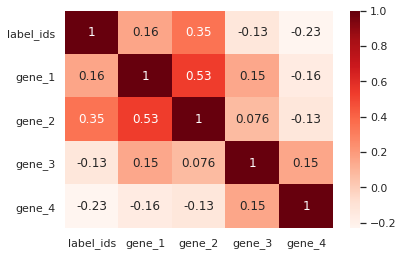

In [28]:
# Join the labels and the data together (this is done through sample_id)
combined_df = samples_df.join(labels_df) 

# Change the type of the labels to categorical to do next line
combined_df["Class"] = combined_df["Class"].astype('category') 

# We can now convert the labels to their categorical numbers (0, 1, 2, and 3)
combined_df["label_ids"] = combined_df["Class"].cat.codes

# Now we can say what genes we want to compare against the labels and get their correlation
columns = ['label_ids', 'gene_1','gene_2','gene_3', 'gene_4']
corr = combined_df[columns].corr()

# Plot the heatmap for the correlation
sns.heatmap(corr, annot=True, cmap='Reds')

### Correlation Heatmap review
From the heatmap above, it looks like gene_2 can be correlated with what type of cancer you may have. We can also see, again, that gene_1 and gene_2 are very correlated as the histogram above showed. Both distributions for gene_1 and gene_2 were nearly identical, so it is no surprise that they correlated highly here.

# 2. Training a Decision Tree algorithm
Now comes the fun part. We know enough about the data now. Next, we will use the data and labels to train a Decision Tree algorithm. There are some things you need to know first before continuing.

## Machine Learning vocab
There are a few terms you must know. These will be used throughout the rest of the workshop, so must be known beforehand.
- **label (or class)**: What we are trying to predict for. In our case, our labels are types of cancer.
- **model**: A Machine Learning algorithm that has been trained with specific parameters, input data, and labels. Every time we train our algorithm, we get out a new model (which we will call a classifier in the code). This model is what you save and load to use in real world use.
- **F1 score**: It is a measure of performance for Machine Learning algorithms. You should not use accuracy when measuring a model's performance. There are correct types of measurements you can use, and F1 score is one of them. It is analogous to accuracy (worst is 0.0 and best is 1.0), so when seeing F1 scores later you can think of it as accuracy/100. If you want to know more, you can view [this Wikipedia page](https://en.wikipedia.org/wiki/F-score) on F1 scores.

## What is a Decision Tree algorithm?
I will quickly run through what a Decision Tree Machine Learning algorithm is. If you would like to know more/have a deeper dive into this algorithm, I would suggest checking out [this link](https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14) which goes to a blog discussing Decision Tree algorithms. I will only be going over exactly what is needed to understand and follow along.

### What is a Decision Tree's data structure
Decision Tree algorithms are a binary tree data structure. This means that each node in the tree will have 2 children nodes or be a leaf with 0 nodes. Technically, binary tree nodes can have 0, 1, or 2 children, but Decision Trees make a yes/no decision at each node, so there will always be 0 or 2 children.

### What is a node in the tree?
As I mentioned, each node is responsible for deciding yes or no decision. In this case, the decision will be based on whether a particular gene is either above or below some expression threshold. For example, a node in the tree may ask the question: is gene_1 <= 2.35? That will have yes go to 1 child and no go to the other child.

The next question you may be asking is, how does the algorithm know which gene to choose and what value to use as the threshold? That is done using Entropy. When a gene has low entropy associated with it, then it provides the most information and is selected for a node. Along with this entropy calculation, it also looks at all values for each gene as well to decide which value would provide the lowest entropy for that gene. To do the actual entropy calculation, in this case, a way to think of it would be to see which gene/expression level combination provides the most "same" labels. This would provide the lowest entropy, or highest information gain.

### Example Decision Tree

Let's think of an example for this:

Let there be 10 samples and 3 genes, so we would have a table like the following:

| sample_id | gene_1 | gene_2 | gene_3 | label |
| :-: | :-: | :-: | :-: | :-: |
| 1 | 0.5 | x | x | PRAD |
| 2 | 0.2 | x | x | PRAD |
| 3 | 4 | x | x | BRCA |
| 4 | 3.34 | x | x | LUAD |
| 5 | 1.24 | x | x | PRAD |
| 6 | 0.89 | x | x | PRAD |
| 7 | 2.74 | x | x | KIRC |
| 8 | 3.45 | x | x | BRCA |
| 9 | 1.75 | x | x | PRAD |
| 10 | 1.98 | x | x | KIRC |

Now, if we are deciding for some node, and we find that gene_1 the lowest entropy using 1.75 as the threshold, then our node would ask (gene_1 <= 1.75). From the table, it looks like all expression levels for gene_1 that are <= 1.75 all have the same label (PRAD). This is the most amount of datapoints that have the same label associated with them, so it has the least entropy for gene_1. We then assume this entropy is also the lowest when comparing gene_2 and gene_3. With that, we get the root of our Decision Tree as follows.

![decision_tree-Page-1.png](decision_tree-Page-1.png)

Now, if we move on to the left-hand side of that tree, we will only be looking at samples whose gene_1 is <= 1.75. We would get a table like:

| sample_id | gene_2 | gene_3 | label |
| :-: | :-: | :-: | :-: |
| 1 | x | x | PRAD |
| 2 | x | x | PRAD |
| 5 | x | x | PRAD |
| 6 | x | x | PRAD |
| 9 | x | x | PRAD |

You will notice that gene_1 is gone. That is because we have already used it as a deciding node further up the tree. In this case, all further labels are the same (PRAD), so we are at a leaf. If a datapoint comes to this leaf, then it will be predicted PRAD. Our Decision Tree would also become:

![decision_tree-Page-2.png](decision_tree-Page-2.png)

We now move to the right side of our root node. This side answered no to the question gene_1 is <= 1.75, so we would get the following table:

| sample_id | gene_2 | gene_3 | label |
| :-: | :-: | :-: | :-: |
| 3 | x | x | BRCA |
| 4 | x | x | LUAD |
| 7 | x | x | KIRC |
| 8 | x | x | BRCA |
| 10 | x | x | KIRC |

Here, we have many different labels. That means this would be another decider node. For now, we will stop, but you can imagine the Decision Tree would continue to be built using this process. The next stage of the Decision Tree would look like the following:

![decision_tree-Page-3.png](decision_tree-Page-3.png)


### Formating data
There is something we can do to help the Decision Tree. Yes, the data we have can be used right now to train a Decision Tree, but this algorithm does not like continuous input. Right now, our gene expression level data is a continuous floating-point number. To help the Decision Tree, we will round to the second decimal place. This will make the data somewhat discrete while keeping the precision needed to make an accurate prediction.

In [29]:
# Round all data to 2 decimal places
samples_formated_df = samples_df.round(2)

# See how data has changed
samples_formated_df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_16373,gene_16374,gene_16375,gene_16376,gene_16377,gene_16378,gene_16379,gene_16380,gene_16381,gene_16382
sample_id,,,,,,,,,,,,,,,,,,,,,
sample_0,0.0,2.02,3.27,5.48,10.43,0,7.18,0.59,0.0,0.0,...,8.75,7.42,4.69,1.33,1.65,3.97,0.00,9.29,0.84,7.89
sample_1,0.0,0.59,1.59,7.59,9.62,0,6.82,0.00,0.0,0.0,...,6.64,7.99,5.71,0.81,2.72,3.26,1.59,3.47,1.18,8.86
sample_2,0.0,3.51,4.33,6.88,9.87,0,6.97,0.45,0.0,0.0,...,8.21,10.38,1.84,0.00,3.00,0.80,0.00,5.53,0.23,9.84
sample_3,0.0,3.66,4.51,6.66,10.20,0,7.84,0.43,0.0,0.0,...,8.09,8.42,5.50,0.43,2.21,1.04,0.00,8.36,0.38,7.70
sample_4,0.0,2.66,2.82,6.54,9.74,0,6.57,0.36,0.0,0.0,...,7.52,12.18,10.31,0.36,1.10,0.36,0.65,9.32,1.05,10.65


### Train and Test dataset
For Machine Learning, you need to split the dataset into 3 separate parts:
1. Training dataset (80%)
2. Validation dataset (10%)
3. Test dataset (10%)

The percentages given above are, usually, what percentage of the original dataset will be put into that respective dataset. So, for example, 80% of the original dataset will be put into the training dataset.

The training dataset is what your algorithm trains on.

The validation dataset is used to validate how well your trained algorithm performs. The validation dataset can be used for testing your trained algorithm multiple times to see how it performs before you O.K. the model.

Finally, the test dataset is what you use to do your final test on your chosen model. It should only be used last to make sure it is data that your model has never seen before. That way, it gives the best chance to show what your model's performance would look like in the real world.

We will be using Sklearn's Train-Test split utility to split the original dataset into the training and testing dataset. We will then be using Cross Validation to split the training dataset into the training and validation datasets to train and validate our model.

### Cross Validation
Cross validation is a nice way to automatically split your training dataset into multiple train/validation datasets, train on each dataset, validate each dataset, and get the average F1 score performance from all trainings. A way to visualize this can be through a table like below.

| run_num | split_1 | split_2 | split_3 | split_4 | split_5 |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | x |  |  |  |  |
| 2 |  | x |  |  |  |
| 3 |  |  | x |  |  |
| 4 |  |  |  | x |  |
| 5 |  |  |  |  | x |

When you do cross validation, you also give how many splits (or folds) you will be doing. So, for the table above, we would say we did 5-fold cross validation since we had 5 folds. The "x" marks the fold that was used as the validation dataset for that run. In cross validation, each fold gets a chance to be a validation dataset for a run. All other folds that are not a validation dataset get combined into the training dataset. This means that, for run number 1 above, split_1 is the validation dataset and split_2-split_5 make up the training dataset. Documentation for Sklearn's cross validation can be found [here](https://scikit-learn.org/stable/modules/cross_validation.html) if you are interested in learning more.


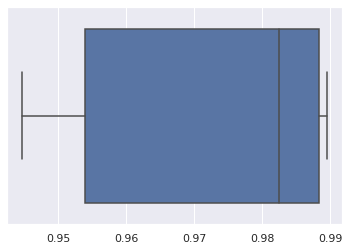

In [30]:
# NOTE: every time you rerun this cell, you will get a different result. Everyone's first run will be the same though.

# Build a default Decision Tree
classifier = tree.DecisionTreeClassifier()

# Separate dataset into train and test dataset
# This split shuffles the data, so we want to give a random seed to make sure we all get same output
x_train, x_test, y_train, y_test = train_test_split(samples_formated_df, labels_df, test_size=0.1)

# Perform cross validation
scores = cross_val_score(classifier, x_train, y_train, cv=5, scoring='f1_macro')

# Let's see what these scores look like
sns.boxplot(x=scores)

# Train the Decision Tree
model = classifier.fit(x_train, y_train)

### Cross Validation review
From the output plot above, it looks like our model performs well. Our Validation F1 score average is around 0.981 with our lowest score being about 0.942. That is great for our model! Something to keep in mind when training Machine Learning algorithms, we never want to see 1.0 F1 score. Yes, we want to get the highest score possible, but there is a point where we start overfitting data (will not get into that too much here, to learn more [visit here](https://en.wikipedia.org/wiki/Overfitting)). In other words, our model memorized the training dataset and will not do well in the real world.

# 3. Visualizing the Decision Tree model generated
Now that we have a good idea of how well our model performs, let's get a view of the Decision Tree behind the model. Below, we will print the tree as text (in dot file format), then we will create an image from that text.

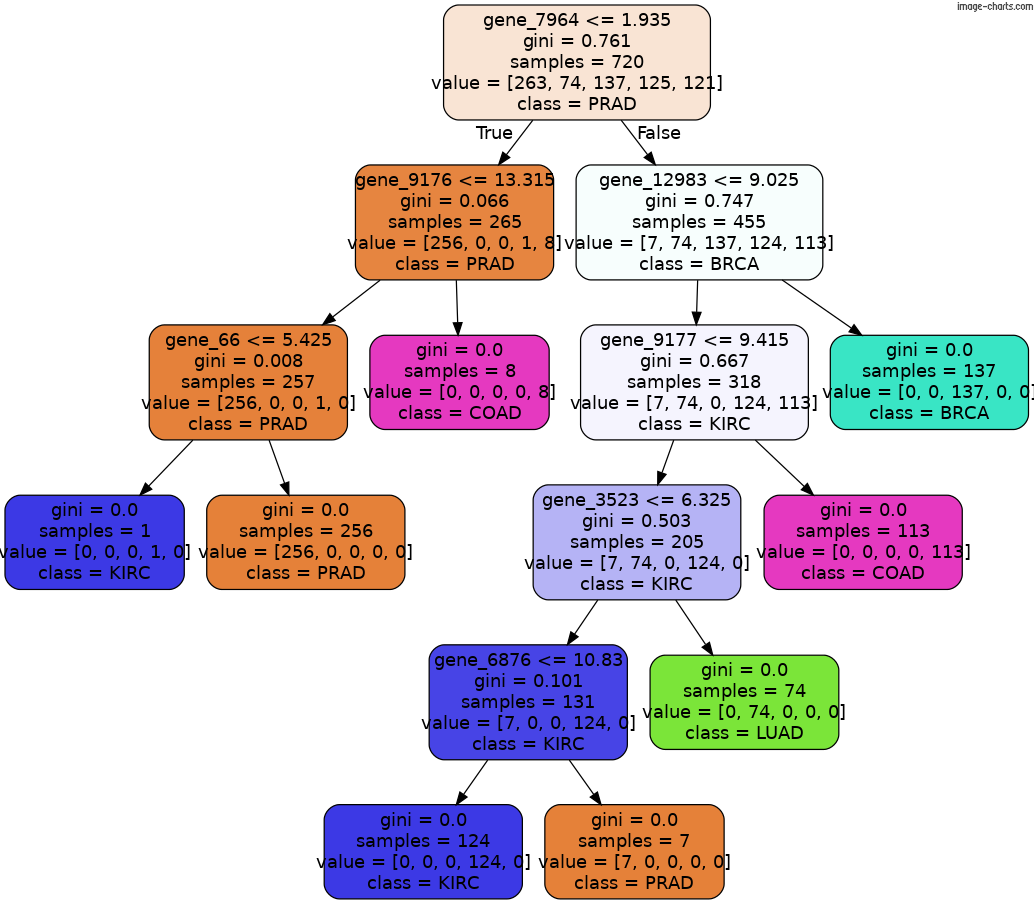

In [31]:
# Get the Decision Tree as text (known as dot format).
# If you cannot get the API to work, delete "out_file=None," below and the dot file will
# be saved to your notebook. From there, you can download it and convert it yourself.
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=list(samples_formated_df.columns),  
                         class_names=pd.unique(labels_df['Class']),  
                         filled=True, rounded=True,  
                         special_characters=False) 

# Normally you would simply install graphviz (call `$sudo apt install graphviz`) and call the following line:
# graph = graphviz.Source(dot_data)
# This would get you the same image, but we cannot install Graphviz here since it is more than a Python library 
# that we would have to install.

# Here is a workaround we can do. We will send the dot file data to an API and have it generate the graph image for us.
import urllib.request
from urllib.parse import quote
with urllib.request.urlopen(f"https://image-charts.com/chart?cht=gv&chl={quote(dot_data, safe='')}") as url:
    contents = url.read()
    
Image(data=contents)

### Decision Tree image review
When viewing the image, we can see that each node comes with some extra data and is colored. I will go over each piece of data in the node in order:
1. The question posed (EX: gene_6876 <= 10.83)
2. Gini score (you can think of this like entropy, the lower the number the better (best is 0.0, worst is 1.0)
3. The number of samples at that particular node
4. List of number of samples per label. Remember our labels are ordered ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD'], so [0, 0, 128, 0] means we have 128 samples that are labeled KIRC and 0 samples labeled any other cancer type
5. The label with the most samples at that node.

##### Gini score
You will notice that the Gini score lowers as you go further down the tree. That is the Decision Tree learning as it trains on the training dataset.

#### Node color
The node colors correspond with the specific cancer type (label). You will notice all nodes that have KIRC as the class are colored the same color, all nodes that have PRAD class are colored a different color, etc.

#### Samples
You will notice that the root node has 720 samples. That corresponds with our training dataset only having 90% of the original dataset (which was 801 samples). With the math, $801 * 0.9 = 720.9$.

# 4. Making some predictions using our model
Finally, the last thing we need to do before shipping our model off to production get a glimpse of how it would work in the real world. This can be done using the test dataset we created a little while ago. All we need to do is pass the test dataset to the model's predict function and it will spit back a list of predictions.

In [32]:
# Make the predictions then print them out to see how they look
predictions = model.predict(x_test)
print(predictions)

['LUAD' 'LUAD' 'LUAD' 'BRCA' 'LUAD' 'BRCA' 'KIRC' 'BRCA' 'BRCA' 'PRAD'
 'KIRC' 'BRCA' 'BRCA' 'BRCA' 'KIRC' 'BRCA' 'BRCA' 'LUAD' 'BRCA' 'BRCA'
 'COAD' 'KIRC' 'BRCA' 'BRCA' 'LUAD' 'LUAD' 'LUAD' 'BRCA' 'PRAD' 'BRCA'
 'BRCA' 'COAD' 'BRCA' 'PRAD' 'LUAD' 'PRAD' 'LUAD' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'LUAD' 'PRAD' 'LUAD' 'LUAD' 'PRAD' 'BRCA' 'BRCA'
 'LUAD' 'LUAD' 'KIRC' 'PRAD' 'PRAD' 'BRCA' 'PRAD' 'BRCA' 'LUAD' 'KIRC'
 'BRCA' 'KIRC' 'BRCA' 'KIRC' 'BRCA' 'BRCA' 'KIRC' 'PRAD' 'COAD' 'BRCA'
 'BRCA' 'BRCA' 'PRAD' 'PRAD' 'PRAD' 'BRCA' 'PRAD' 'BRCA' 'PRAD' 'BRCA'
 'COAD']


### Checking predictions
From the predictions above, we can see that they are the string representation of the labels rather than their integer representation. Now, we just need to get the F1 score by comparing the actual labels (y_test) against our predictions.

In [33]:
# Get the F1 score for out predictions
score = f1_score(y_test, predictions, labels=pd.unique(labels_df['Class']), average="macro")
print(f"Test dataset F1 score: {score}")

Test dataset F1 score: 1.0


# Conclusion
Wow! Our model performed perfectly on the test dataset. For the test dataset, we would like to see it have near perfect F1 score as this is how the model would be predicting in the real world. If it can predict perfectly here, then there is a good chance it will perform near perfect when out in production.

Well done! You have finished the Machine Learning workshop. You have now gotten to see how setting up, training, and testing a simple Machine Learning algorithm is. This is just brushing the surface of Machine Learning. Hopefully, you learned something that you can take away and use. Thank you for going through the workshop!